In [1]:
from datetime import datetime
from typing import List
from typing import Union

import numpy as np
import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image as PILImage
from torch.utils.data import DataLoader

import pyml
from models import DiscriminatorPixelMse, DiscriminatorVggMse, DiscriminatorBaselineNetwork

In [2]:
torch.cuda.is_available()

True

In [3]:
dataset = pyml.ImagesDataset.from_dirs_recursive(roots=["datasets/flowers102processed"], channels_order='chw')
batch_size = 8

if torch.cuda.is_available():
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, pin_memory_device='cuda')
else:
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
class GeneratorESPCN(nn.Module):
    def __init__(self, channels: int, upscale: int):
        super(GeneratorESPCN, self).__init__()
        assert upscale == 4

        self.layers = nn.Sequential(
            nn.Conv2d(3, channels, kernel_size=5, padding='same'),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels, channels, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels, channels, kernel_size=3, padding=2, dilation=2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels, channels, kernel_size=3, padding=4, dilation=4),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels, channels, kernel_size=3, padding=8, dilation=8),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels, channels, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),

            nn.Conv2d(channels, 32 * 2**2, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.PixelShuffle(2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 16 * 2**2, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.PixelShuffle(2),

            nn.Conv2d(16, 64, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 3, kernel_size=3, padding='same'),
        )

    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [5]:
class GanHelper:
    def __init__(self, data_loader: DataLoader):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.data_loader = data_loader
        scale = 4
        self.generator = GeneratorESPCN(channels=128, upscale=scale).to(self.device)

        self.d_pixel_mse = DiscriminatorPixelMse(weight=1.0)
        self.d_vgg_mse = DiscriminatorVggMse(weight=0.0001, inpad_size=16).to(self.device)
        self.d_vgg_mse_x2 = DiscriminatorVggMse(weight=0.0001, prescale=2, inpad_size=16).to(self.device)
        self.d_baseline = DiscriminatorBaselineNetwork(generator_weight=0.001, mid_channels=32, inpad_size=16, deep=True).to(self.device)

        self.losses = []
        self.losses_print_step = 1000

    def add_loss(self, losses: List[torch.Tensor]):
        self.losses.append([loss.item() for loss in losses])
        if self.losses_print_step is not None and len(self.losses) % self.losses_print_step == 0:
            av_loss = np.average(np.array(self.losses[-self.losses_print_step:]), axis=0)
            print(f"{len(self.losses)}: {av_loss}")

    def generate_data(self):
        while True:
            for label in self.data_loader:
                yield label

    def downsample_4x(self, x: torch.Tensor) -> torch.Tensor:
        _, _, h, w = x.size()
        return F.interpolate(x, size=(h // 4, w // 4), mode='bilinear', antialias=True)

    def upsample_4x(self, x: torch.Tensor) -> torch.Tensor:
        _, _, h, w = x.size()
        return F.interpolate(x, size=(h * 4, w * 4), mode='bilinear')

    def train(self, *, steps: int, lr_g: float = 0.0, lr_d: float = 0.0):
        generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr_g)
        discriminator_optimizer = torch.optim.Adam(self.d_baseline.parameters(), lr=lr_d)

        self.generator.train()
        self.d_baseline.train()

        for step, label in zip(range(steps), self.generate_data()):
            label = label.to(self.device)
            label.requires_grad = False

            x = self.downsample_4x(label)

            # train generator
            if lr_g != 0.0:
                generator_optimizer.zero_grad()
                y = self.generator(x)
                g_losses = [f.loss(y, label) for f in
                            [self.d_pixel_mse, self.d_vgg_mse, self.d_vgg_mse_x2, self.d_baseline]]
                loss = sum(g_losses)
                loss.backward()
                generator_optimizer.step()
            else:
                g_losses = [torch.zeros(size=[1], device=self.device)]

            # train discriminator
            if lr_d != 0.0:
                discriminator_optimizer.zero_grad()
                y = self.generator(x)
                y = y.detach()
                d_loss = self.d_baseline.loss_for_discriminator(y, label)
                d_loss.backward()
                discriminator_optimizer.step()
            else:
                d_loss = torch.zeros(size=[1], device=self.device)

            self.add_loss(g_losses + [d_loss])

    def demonstrate(self, label: Union[np.ndarray, torch.Tensor]) -> PILImage:
        if isinstance(label, np.ndarray):
            if len(label.shape) == 3:
                label = label[np.newaxis]
            label = torch.from_numpy(label)
        assert isinstance(label, torch.Tensor)
        label = label.to(self.device)

        self.generator.eval()
        x = self.downsample_4x(label)
        y = self.generator(x)
        x4x = self.upsample_4x(x)

        triple = torch.cat([x4x, y, label], dim=3)
        pic = triple.cpu().detach().numpy()[0]
        pic = np.moveaxis(pic, 0, 2)
        pic = np.clip(pic, 0.0, 1.0)
        img = PILImage.fromarray((pic * 255.0).astype(np.uint8))
        return img

    def save_model(self) -> str:
        suffix = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
        torch.save(self.generator.state_dict(), f"models/espcn/generator_espcn_{suffix}.pth")
        torch.save(self.d_baseline.state_dict(), f"models/espcn/discriminator_baseline_{suffix}.pth")
        return suffix

    def load_model(self, suffix: str):
        self.generator.load_state_dict(torch.load(f"models/espcn/generator_espcn_{suffix}.pth"))
        self.d_baseline.load_state_dict(torch.load(f"models/espcn/discriminator_baseline_{suffix}.pth"))

In [6]:
gan_helper = GanHelper(data_loader)

/home/lgor/projects/2023/pyenv310/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [7]:
gan_helper.train(steps=50 * len(dataset) // batch_size, lr_g=0.0003, lr_d=0.0001)

1000: [0.01597897 0.011089   0.01190447 0.00371522 0.09301032]
2000: [0.00439758 0.00789519 0.00472609 0.0033406  0.18354454]
3000: [0.00387314 0.00731544 0.00422031 0.00304041 0.23862933]
4000: [0.00366066 0.00693583 0.00396287 0.00286632 0.28242717]
5000: [0.0034875  0.00664542 0.00370878 0.00265487 0.30153291]
6000: [0.00341483 0.0065057  0.00360567 0.0025762  0.32615992]


In [8]:
gan_helper.train(steps=100 * len(dataset) // batch_size, lr_g=0.0001, lr_d=0.00003)

7000: [0.00323496 0.00643287 0.00348915 0.00276983 0.29011879]
8000: [0.00312542 0.00644948 0.00342452 0.00257764 0.29638007]
9000: [0.00300437 0.00626289 0.00327803 0.00225878 0.34871641]
10000: [0.00300822 0.00615539 0.00320518 0.00225543 0.33528214]
11000: [0.0030153  0.00610869 0.00320215 0.00232477 0.32459642]
12000: [0.00298389 0.00607018 0.00318837 0.00235123 0.33137616]
13000: [0.00299294 0.00603761 0.0031508  0.00231252 0.35031762]
14000: [0.0029998  0.00599786 0.00311544 0.00239679 0.32554638]
15000: [0.00299353 0.00597436 0.00311975 0.00236819 0.33427226]
16000: [0.00296988 0.00595977 0.00311754 0.00250375 0.30555397]
17000: [0.00300382 0.00596009 0.00311015 0.00253632 0.29206515]
18000: [0.00295794 0.00593766 0.00309375 0.00231592 0.34587112]
19000: [0.0029352  0.00591967 0.00308652 0.0025819  0.29419537]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


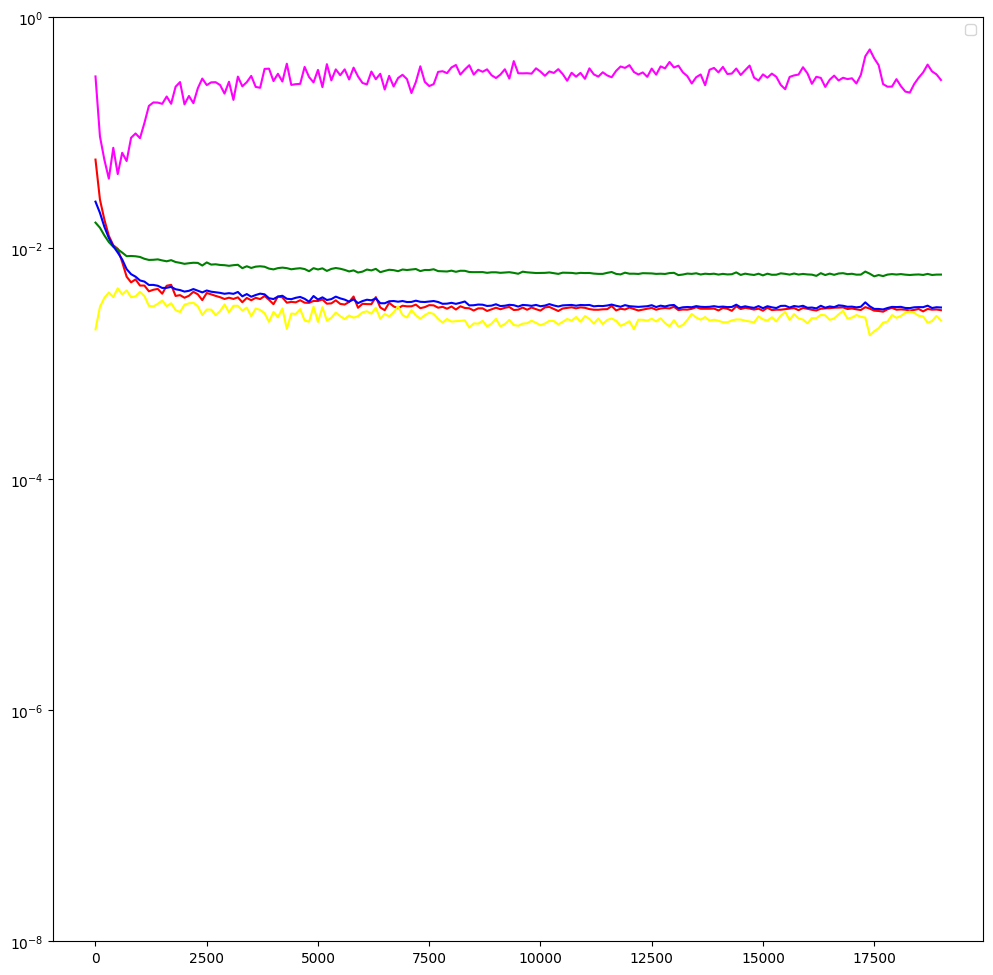

In [9]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_ylim(0.00000001, 1)

def my_plot(lst: List[float], av: int):
    for i, color in enumerate(["red", "green", "blue", "yellow", "magenta"]):
        arr = np.array(lst)[:, i]
        arr = arr[:arr.shape[0] // av * av]
        arr = arr.reshape(-1, av).mean(axis=1)
        ax.plot([i * av for i in range(arr.shape[0])], arr, c=color)

my_plot(gan_helper.losses, av=100)

ax.legend()
plt.show()

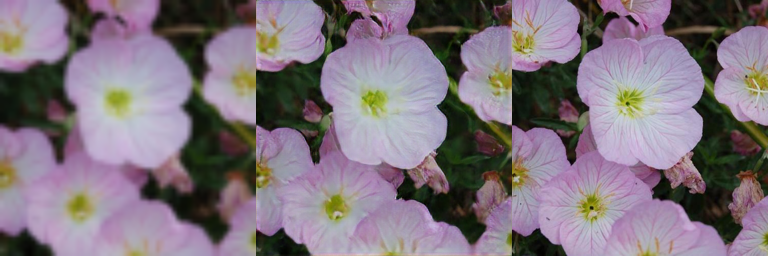

In [10]:
gan_helper.demonstrate(dataset[0])

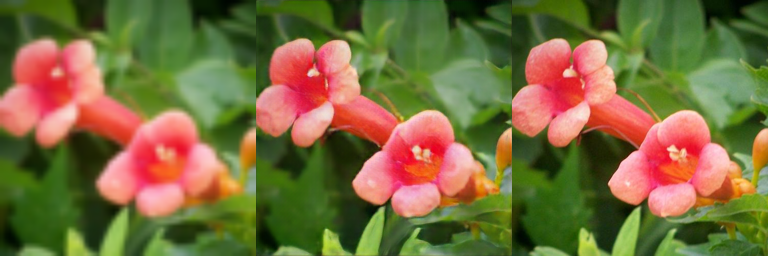

In [11]:
gan_helper.demonstrate(dataset[6])

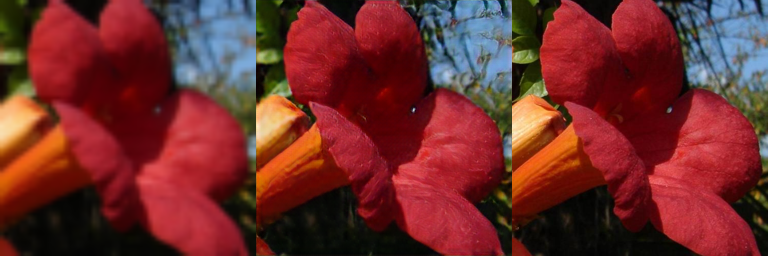

In [12]:
gan_helper.demonstrate(dataset[7])

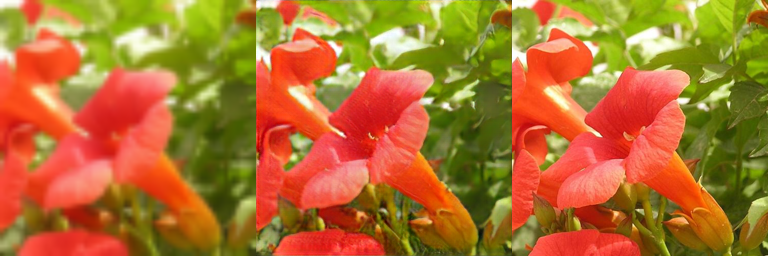

In [13]:
gan_helper.demonstrate(dataset[8])

In [14]:
gan_helper.save_model()

'2023-05-04-14-16-53'